# Assignment 7 
## Clustering and Classification
### Isabel Osgood

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import cluster
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss


import statsmodels.api as sm

In [2]:
wine = pd.read_csv("wine-clustering.csv")
print(wine.shape) #fits citeria 

(178, 13)


In [3]:
scale = StandardScaler()
scaled_wine = pd.DataFrame(scale.fit_transform(wine), columns=wine.columns)
scaled_wine.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


In [4]:
pca = PCA(n_components=2)
pca = pca.fit(scaled_wine)
wine_pca = pca.transform(scaled_wine)
wine_pca.shape

(178, 2)

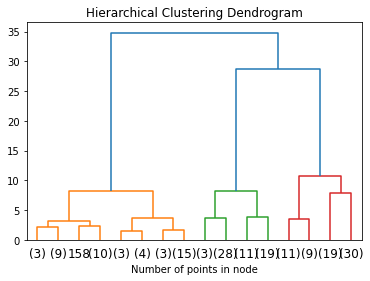

In [5]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1 # leaf node
            else:
                 current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
 # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
model = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(wine_pca)


plot_dendrogram(model, truncate_mode='level', p=3)
plt.title('Hierarchical Clustering Dendrogram')

plt.xlabel("Number of points in node")
plt.show()

#dendrogram shows us 3 is best number of cluster 

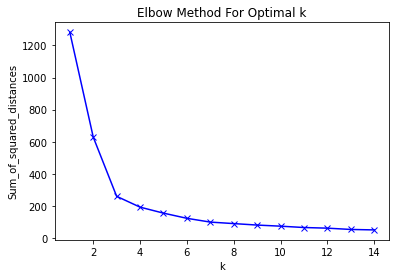

In [6]:
#lets confirm above w elbow method 
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(wine_pca)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
#confirms 3 is best no of clust

In [7]:
clu = KMeans(n_clusters=3)
clu = clu.fit(wine_pca)
y_pred = clu.predict(wine_pca)


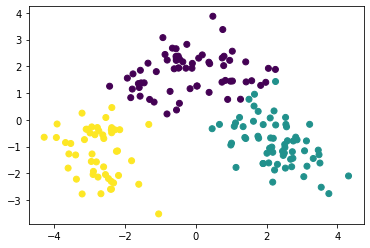

In [8]:
# visualize the clusters and color by predicted clusters
plt.scatter(wine_pca[:,0], wine_pca[:,1], c=y_pred)

In [9]:
wine['cat'] = y_pred

logreg = LogisticRegression(max_iter=10000, warm_start=True)
y = wine['cat']
X = wine.drop(['cat'], axis =1)
logreg = logreg.fit(X, y)


In [10]:
param_grid = {'C': [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]}
search = GridSearchCV(estimator=logreg, param_grid=param_grid)
search = search.fit(X, y)
best = search.best_estimator_
print(best.score(X, y))

0.9775280898876404


In [11]:
wine.groupby('cat').mean()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
cat,,,,,,,,,,,,,
0,12.238308,1.931385,2.219385,19.898462,92.830769,2.204308,1.989231,0.365538,1.587692,2.992615,1.051631,2.769231,506.353846
1,13.659219,1.975781,2.463750,17.596875,107.312500,2.859688,3.012656,0.290000,1.921719,5.406250,1.069688,3.157188,1082.562500
2,13.151633,3.344490,2.434694,21.438776,99.020408,1.678163,0.797959,0.450816,1.163061,7.343265,0.685918,1.690204,627.551020


### Describe the clusters 

cluster 0 is made up of wine high in Mali Acid, low in total phenols and glavanoids, hihg in color intensity and low in hue and OD280. 

cluster 1 is made up of slightly more alcholic wine, high in magnesium, total phenols, flavanoids, proanthocyanins, OD280. It also contains nearly all wine high in proline. 

cluster 2 is made up of wine that is less alcoholic, has low levels of magnesium and is low in color insensity of proline. 

I am not a sommelier nor am I a chemist so I really don't know what any of this means in terms of flavor or type of wine. 